<a href="https://colab.research.google.com/github/RubenLewis003/Pricing-and-hedging-VIX-options/blob/main/FM50Dynamictradingneuralnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import seaborn as sns

plt.style.use('ggplot')


np.set_printoptions(suppress=True)
np.set_printoptions(precision=5)

In [2]:
vol = 0.07659374420551314
Vmean = 2.910104770529511
a = 0.024498317590460172
F0 = 13.2
T=18
Timesteps = 18
paths = 10000
dt = T/Timesteps
BpD = 100000/18

def simulating_OU(V0, timesteps,Vmean,vol,a,paths):
  dt = 1
  V = np.zeros((paths, timesteps+1))
  V[:,0] = V0
  DW = np.random.normal(0,1, size=(paths,timesteps))
  for i in range(timesteps):
    V[:,i+1] = V[:,i] - a*(V[:,i] - Vmean)*dt + vol*np.sqrt(dt)*DW[:,i]
  return V

futuressimulation = np.exp(simulating_OU(np.log(13.2),18,Vmean,vol,a,10000))
returns = np.diff(futuressimulation, axis=1) / futuressimulation[:,:-1]

print(f"Futures simulation shape: {futuressimulation}")
print(f"Price differences shape: {returns.shape}")
print(f"Initial price: {F0}")
print(f"Mean final price: {np.mean(futuressimulation[:, -1]):.2f}")
print(f"Std final price: {np.std(futuressimulation[:, -1]):.2f}")

Futures simulation shape: [[13.2     13.43032 13.95654 ... 19.15798 20.04999 19.87144]
 [13.2     13.46141 13.42215 ... 13.4067  11.98991 10.07927]
 [13.2     12.87447 12.54853 ... 10.82766 12.26087 13.46208]
 ...
 [13.2     15.07663 14.10806 ... 19.47763 17.5913  16.72358]
 [13.2     12.88958 12.52234 ... 12.1751  12.57038 13.50149]
 [13.2     12.61497 13.41573 ... 14.99196 13.7116  16.08123]]
Price differences shape: (10000, 18)
Initial price: 13.2
Mean final price: 15.45
Std final price: 4.22


In [3]:
tim = np.linspace(0,T,Timesteps+1)
X = np.zeros((paths,Timesteps, 3))

for i in range(Timesteps):
  X[:,i, 0] = tim[i]
  X[:,i, 1] = futuressimulation[:,i]
  if i > 0:
    X[:,i, 2] = (futuressimulation[:,i] - futuressimulation[:,i-1])/futuressimulation[:,i-1]
  else:
    X[:,i, 2] = 0

print(f"Shape of X: {X.shape}")

pricemean = np.mean(X[:,:,1])
pricestd = np.std(X[:,:,1])

Xtrain = X.copy()
Xtrain[:,:,0] = X[:,:,0]
Xtrain[:,:,1] = (X[:,:,1] - pricemean)/pricestd
Xtrain[:,:,2] = X[:,:,2]

print(f"Shape of Xtrain: {Xtrain.shape}")

Shape of X: (10000, 18, 3)
Shape of Xtrain: (10000, 18, 3)


In [4]:
cutfuturessimulation = tf.constant(futuressimulation[:,:-1], dtype=tf.float32)

In [5]:
def metrics(positions, training):


    valueofinvestment = cutfuturessimulation*positions

    averagedailyposition = np.mean(positions, axis=0)
    dailypositionstd = np.std(positions, axis=0)

    print('\nTrading metrics:')
    print(f'Position shape: {positions.shape}')
    print(f'Mean value of investment: {np.mean(valueofinvestment)}')
    print(f'Position range: [{np.min(positions)}, {np.max(positions)}]')
    print(f'Mean absolute position: {np.mean(np.abs(positions)):.2f}')
    print(f'Std position: {dailypositionstd}')

    #Performance metrics

    dailyPnL = positions * cutfuturessimulation * returns
    averagePnL = np.mean(dailyPnL)
    dailyPnLstd = np.std(dailyPnL)
    totalPnL = np.sum(dailyPnL, axis=1)
    meantotalPnL = np.mean(totalPnL)
    totalPnLstd = np.std(totalPnL)
    maxPnL = np.max(totalPnL)
    minPnL = np.min(totalPnL)
    totalPnLstd = np.std(totalPnL)
    wealthevolution = np.cumsum(dailyPnL, axis=1)
    meanwealthevolution = np.mean(wealthevolution, axis=0)
    wealthevolutionstd = np.std(wealthevolution, axis=0)
    sharperatio = np.mean(totalPnL)/np.std(totalPnL)

    print('\nPerformance metrics:')
    print(f'Mean daily PnL: {averagePnL}')
    print(f'Daily PnL std: {dailyPnLstd}')
    print(f'Mean Total PnL: {meantotalPnL}')
    print(f'Total PnL std: {totalPnLstd}')
    print(f'Total PnL range: [{minPnL}, {maxPnL}]')
    print(f'Mean modified Sharpe ratio: {sharperatio}')
    print(f'Mean wealth evolution: {meanwealthevolution}')
    print(f'Wealth evolution std: {wealthevolutionstd}')

    winrate = np.sum(totalPnL > 0) / len(totalPnL)
    print(f'Win rate: {winrate:.2%}')

    valueatrisk = np.percentile(totalPnL, 5)
    print(f'Value at risk (95th percentile): {valueatrisk}')

#-------------------------------------------------------------------------------------------------------

    #plt.figure(figsize=(10, 6))
    #plt.plot(training.history['loss'], label='Training loss')
    #plt.plot(training.history['val_loss'], label='Validation loss')
    #plt.xlabel('Epoch', fontsize=10, fontweight='bold')
    #plt.ylabel('Loss', fontsize=10, fontweight='bold')
    #plt.legend()
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()

#-----------------------------------------------------------------------------------------------------------------------


    plt.figure(figsize=(10, 6))

    n, bins, patches = plt.hist(totalPnL, bins=50, alpha=0.7, color='steelblue',
                               edgecolor='darkblue', linewidth=0.8, label='Total PnL')

    plt.xlabel('Cumulative P&L ($)', fontsize=10, fontweight='bold')
    plt.ylabel('Frequency', fontsize=10, fontweight='bold')
    plt.figure(figsize=(10, 6))

#--------------------------------------------------------------------------------------------------------------------------------------

    plt.figure(figsize=(10, 6))

    pos_data = positions.flatten()
    pos_data = pos_data[~np.isnan(pos_data)]

    n, bins, patches = plt.hist(pos_data, bins=50, alpha=0.7, color='forestgreen',
                               edgecolor='darkgreen', linewidth=0.8)

    plt.xlabel('Position Size (Contracts)', fontsize=10, fontweight='bold')
    plt.ylabel('Frequency', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------------------------

    plt.figure(figsize=(10, 6))

    wealthevolution0 = np.hstack((np.zeros((10000,1)), wealthevolution))

    t = np.linspace(0, len(tim)-1, len(tim))
    upper = np.percentile(wealthevolution0, 95, axis=0)
    middle = np.mean(wealthevolution0, axis=0)
    lower = np.percentile(wealthevolution0, 5, axis=0)
    p75 = np.percentile(wealthevolution0, 75, axis=0)
    p25 = np.percentile(wealthevolution0, 25, axis=0)

    plt.fill_between(tim, lower, upper, alpha=0.15, color='steelblue', label='5th-95th percentile')
    plt.fill_between(tim, p75, p25, alpha=0.2, color='steelblue', label='10th-90th percentile')

    plt.plot(tim, middle, color='darkblue', linewidth=2.5, label='Mean')
    plt.plot(tim, upper, color='steelblue', linewidth=1, alpha=0.8, linestyle='--')
    plt.plot(tim, lower, color='steelblue', linewidth=1, alpha=0.8, linestyle='--')


    plt.plot(tim, wealthevolution0[1,:], color='crimson', linewidth=1.5, alpha=0.6,
                label='Sample path')

    plt.xlabel('Time (days)', fontsize=10, fontweight='bold')
    plt.ylabel('Total Profit', fontsize=10, fontweight='bold')
    plt.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------

    plt.figure(figsize=(10, 6))

    averagedailyposition0 = np.hstack((0, averagedailyposition))
    dailypositionstd0 = np.hstack((0, dailypositionstd))

    plt.plot(tim, averagedailyposition0, color='steelblue', linewidth=2,
            linestyle=':', alpha=0.8, label='Position Trend')

    plt.errorbar(tim, averagedailyposition0, yerr=dailypositionstd0,
                fmt='none', ecolor='lightsteelblue', alpha=0.6,
                capsize=4, capthick=1.5, elinewidth=1.5,
                label='±1 Std Dev', zorder=3)

    colors = ['darkgreen' if pos > 0.1 else 'darkred' if pos < -0.1 else 'gray'
              for pos in averagedailyposition0]

    sizes = [60 if abs(pos) > 0.5 else 40 for pos in averagedailyposition0]
    for i, (day, pos, color, size) in enumerate(zip(tim, averagedailyposition0, colors, sizes)):
        plt.scatter(day, pos, color=color, s=size, alpha=0.8,
                  edgecolors='white', linewidths=1.5, zorder=5)

    plt.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.6)

    max_pos = max(abs(np.max(averagedailyposition0)), abs(np.min(averagedailyposition0)))
    if max_pos > 0:
        plt.axhspan(0.1, max_pos * 10, alpha=0.1, color='green', label='Long Zone')
        plt.axhspan(-max_pos * 10, -0.1, alpha=0.1, color='red', label='Short Zone')

    plt.xlabel('Day', fontsize=10, fontweight='bold')
    plt.ylabel('Mean Position Size (Contracts)', fontsize=10, fontweight='bold')
    plt.ylim(-500, 500)
    plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [6]:
cutfuturessimulation = tf.constant(futuressimulation[:,:-1], dtype=tf.float32)

In [7]:
def betterutility(ytrue, ypred):
  #Budget = £100,000
  #Budgetperday = £100,000/18 days

  valueofinvestment = ypred * BpD

  dailyPnL = valueofinvestment * ytrue
  totalPnL = K.sum(dailyPnL, axis=1)

  meanPnL = K.mean(totalPnL)
  PnLstd = K.std(totalPnL)

  sharperatio = meanPnL/PnLstd

  return -sharperatio

In [8]:
def shtradingNN(Timesteps, inputdimension=3, l2_reg=0.01):
    inputs = keras.layers.Input(shape=(Timesteps, inputdimension))
    x = keras.layers.LayerNormalization()(inputs)

    x = keras.layers.Dense(64, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(x)

    x = keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(32, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = keras.layers.Dropout(0.1)(x)

    position = keras.layers.Dense(1, activation='tanh')(x)
    positions = keras.layers.Reshape((Timesteps,))(position)

    model = keras.Model(inputs=inputs, outputs=positions)
    return model

In [9]:
def shtradingNN1(Timesteps, inputdimension=3, l2_reg=0.01):
    inputs = keras.layers.Input(shape=(Timesteps, inputdimension))
    x = keras.layers.LayerNormalization()(inputs)

    x = keras.layers.Dense(64, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(x)

    x = keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(32, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = keras.layers.Dropout(0.1)(x)

    position = keras.layers.Dense(1, activation='tanh')(x)
    positions = keras.layers.Reshape((Timesteps,))(position)

    model = keras.Model(inputs=inputs, outputs=positions)
    return model

In [10]:
smodel1 = shtradingNN(Timesteps, inputdimension=3)

smodel1.compile(optimizer='adam', loss=betterutility)
smodel1.summary()

straining1 = smodel1.fit(Xtrain, returns, epochs=15, batch_size=32, validation_split=0.2, verbose=1)
spositions1 = (BpD/cutfuturessimulation)*smodel1.predict(Xtrain, batch_size=32)
spositions1 = np.array(spositions1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 18, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 18, 3)          │             6 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 18, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18, 128)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 18, 1)          │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 18)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,207 (75.03 KB)

 Trainable params: 19,079 (74.53 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.8327 - val_loss: -0.3683
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: -0.5285 - val_loss: -0.7625
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: -0.8207 - val_loss: -0.8890
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: -0.8501 - val_loss: -0.8982
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: -0.8657 - val_loss: -0.8958
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: -0.8484 - val_loss: -0.8007
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: -0.8843 - val_loss: -0.9027
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: -0.9258 - val_loss: -0.9016
Epoch 9/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: -0.9606 - val_loss: -0.9227
Epoch 10/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: -0.8986 - val_loss: -0.8835
Epoch 11/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: -0.9069 - val_loss: -0.9177
Epoch 12/15
250/250 ━━━━━━━━


Trading metrics:
Position shape: (10000, 18)
Mean value of investment: 2980.819580078125
Position range: [8.300323486328125, 1145.1324462890625]
Mean absolute position: 241.53
Std position: [  0.06229 124.76122 174.28957 187.24069 193.10883 195.13295 195.7923
 196.76068 196.32906 194.82295 192.51543 190.37204 187.7822  185.57266
 183.04677 180.24515 177.47896 175.12534]

Performance metrics:
Mean daily PnL: 37.42241287231445
Daily PnL std: 287.0974426269531
Mean Total PnL: 673.6033935546875
Total PnL std: 834.0337524414062
Total PnL range: [-4745.68896484375, 2811.598388671875]
Mean modified Sharpe ratio: 0.8076452612876892
Mean wealth evolution: [ 58.77165 111.82161 162.31807 207.7844  252.88753 292.8062  326.6505
 363.59958 401.92847 438.4906  471.2282  505.4911  535.2272  564.5391
 592.6921  622.878   649.7083  673.604  ]
Wealth evolution std: [428.50812 579.37646 656.5063  709.2596  741.6265  768.2881  793.1833
 812.9334  821.3436  826.5494  828.9453  833.3667  837.27264 840.4497


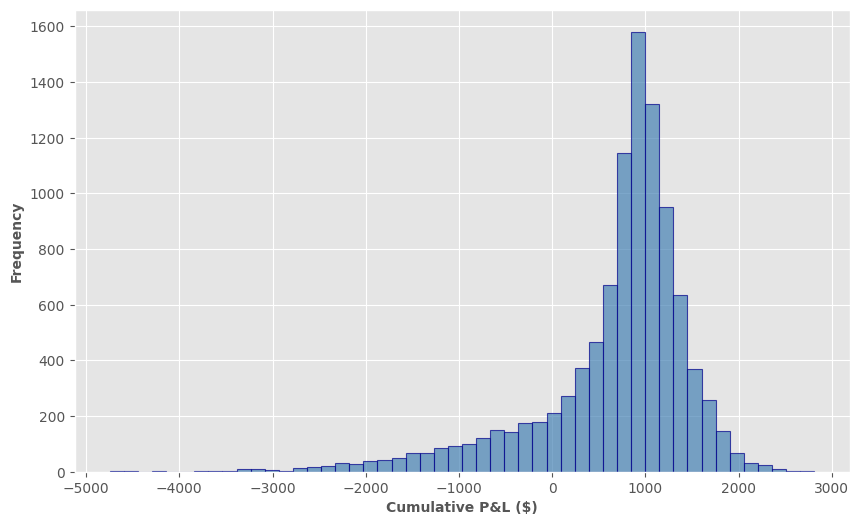

<Figure size 1000x600 with 0 Axes>

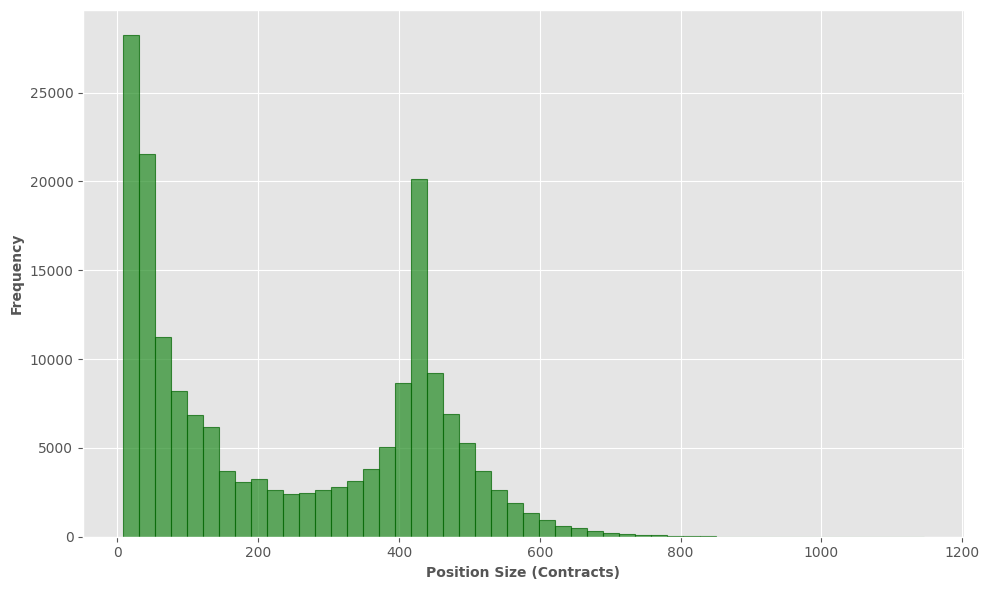

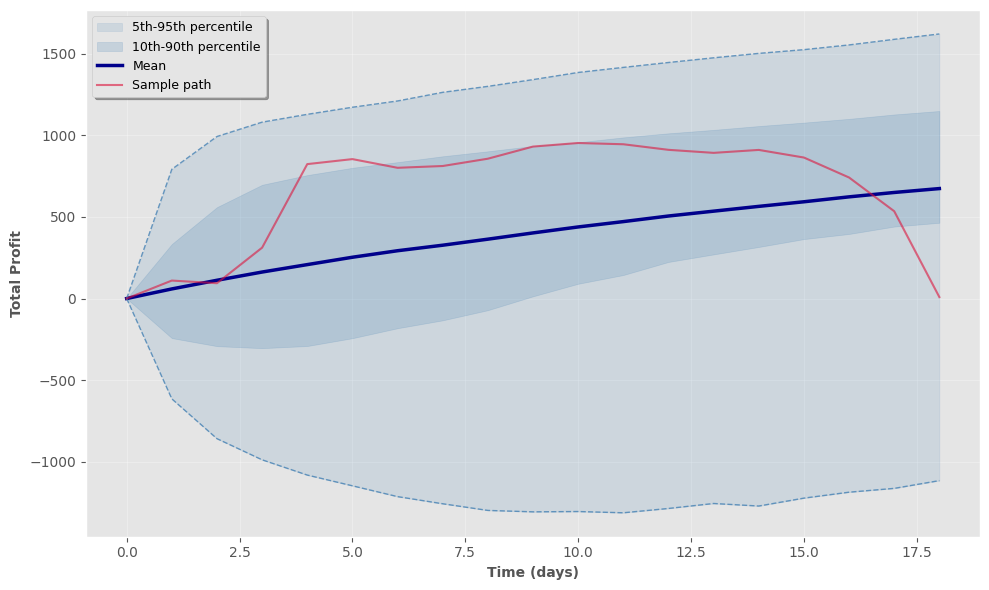

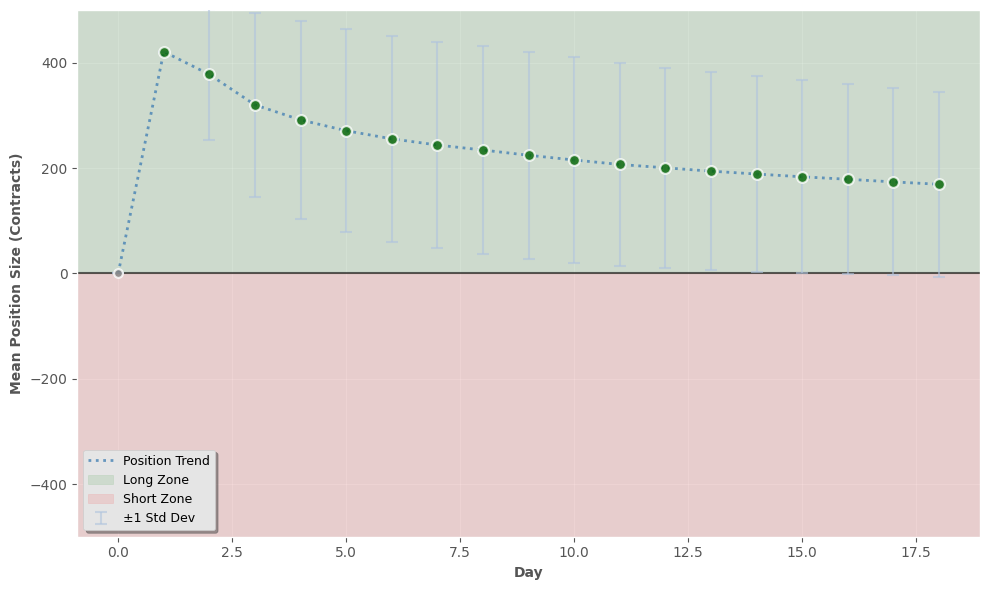

In [11]:
z = metrics(spositions1,straining1)

In [12]:
def ourutility2(ytrue, ypred):
  lamda = 2
  wbar=1000

  valueofinvestment = ypred * BpD
  dailyPnL = valueofinvestment * ytrue
  totalPnL = K.sum(dailyPnL, axis=1)

  C = (lamda * totalPnL)/wbar

  maxC = K.max(C)
  expPnL = K.exp(C - maxC)
  meanexpPnL = K.mean(expPnL)
  disutility = (1/lamda) * (maxC + K.log(meanexpPnL))

  return -disutility

In [13]:
smodel2 = shtradingNN1(Timesteps, inputdimension=3)
smodel2.compile(optimizer='adam', loss=ourutility2)
smodel2.summary()

straining2 = smodel2.fit(Xtrain, returns, epochs=15, batch_size=32, validation_split=0.2, verbose=1)
spositions2 = (BpD/cutfuturessimulation)*smodel2.predict(Xtrain, batch_size=32)
spositions2 = np.array(spositions2)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 18, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 18, 3)          │             6 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 18, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 18, 128)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 18, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 18, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 18, 1)          │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 18)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,207 (75.03 KB)

 Trainable params: 19,079 (74.53 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0592 - val_loss: -1.8562
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: -1.7993 - val_loss: -2.1860
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: -2.2133 - val_loss: -2.2649
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: -2.3556 - val_loss: -2.5430
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: -2.3989 - val_loss: -2.6149
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: -2.5120 - val_loss: -2.6725
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: -2.5090 - val_loss: -2.7116
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: -2.5664 - val_loss: -2.7390
Epoch 9/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: -2.6246 - val_loss: -2.7589
Epoch 10/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: -2.6029 - val_loss: -2.7744
Epoch 11/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: -2.6673 - val_loss: -2.7867
Epoch 12/15
250/250 ━━━━━━━━


Trading metrics:
Position shape: (10000, 18)
Mean value of investment: 5554.52001953125
Position range: [142.5901336669922, 1149.2684326171875]
Mean absolute position: 403.65
Std position: [  0.02444  31.90725  44.92455  53.89149  61.11856  66.66519  72.08518
  77.25672  81.69605  84.90501  87.77725  90.62219  93.36414  96.06731
  98.52708 100.69624 102.3528  104.46668]

Performance metrics:
Mean daily PnL: 54.077598571777344
Daily PnL std: 430.2905578613281
Mean Total PnL: 973.3969116210938
Total PnL std: 1509.493408203125
Total PnL range: [-4753.3837890625, 6721.02197265625]
Mean modified Sharpe ratio: 0.6448500752449036
Mean wealth evolution: [ 58.75824 114.86721 177.71661 232.76778 292.45602 350.4587  406.22287
 462.4276  521.04224 577.5463  630.54443 685.0881  734.4188  783.191
 829.4755  882.8644  931.6618  973.3955 ]
Wealth evolution std: [ 428.40945  602.67     727.7647   825.65967  904.7484   985.0826
 1060.7815  1123.2544  1174.2313  1218.1223  1265.1874  1305.1663
 1346.784

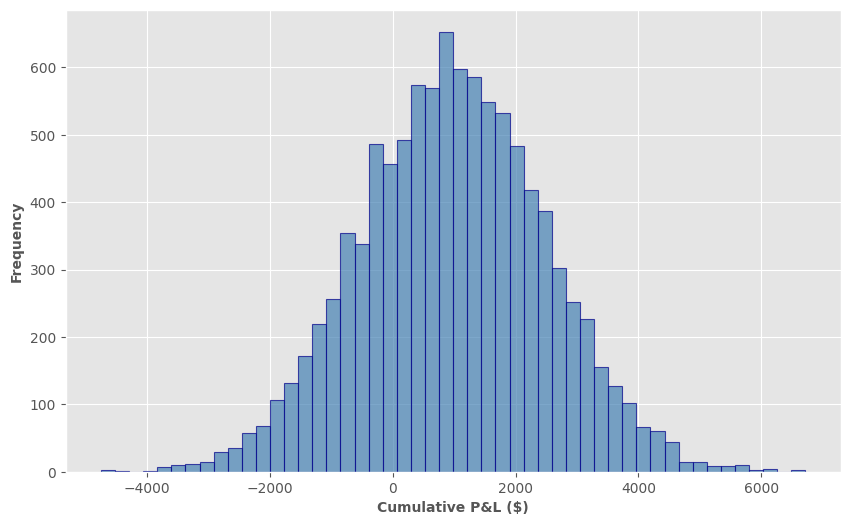

<Figure size 1000x600 with 0 Axes>

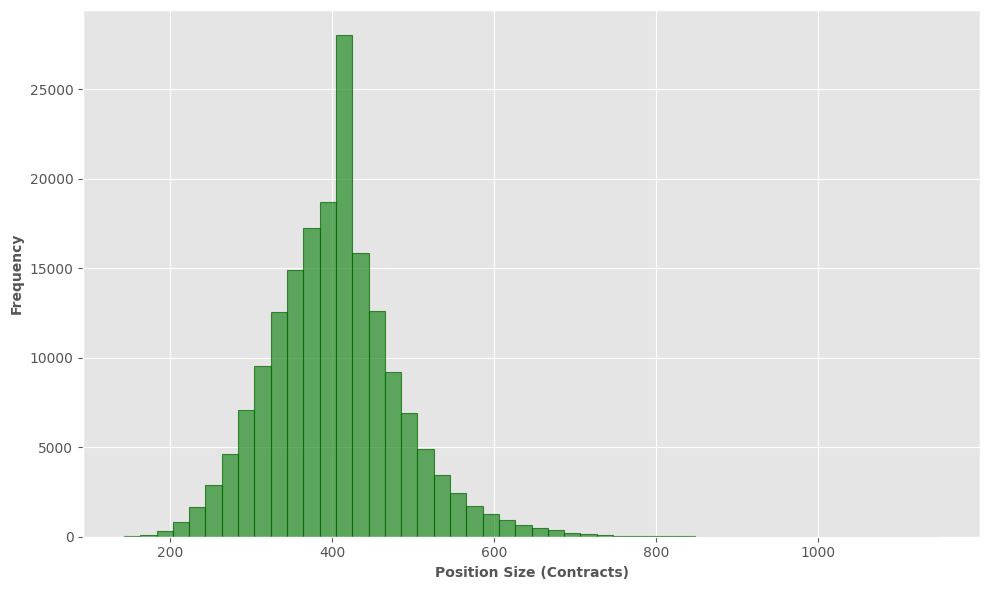

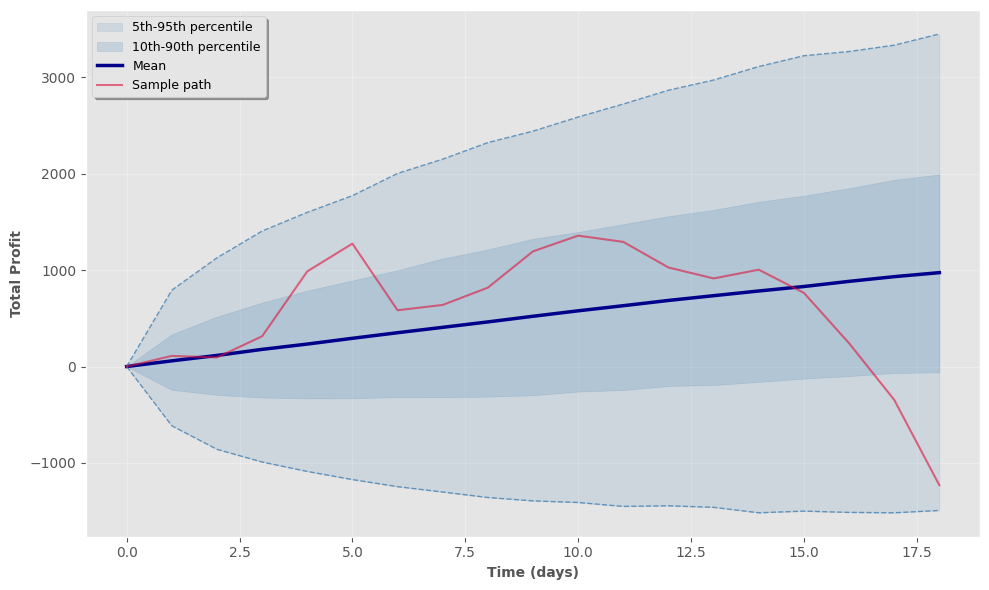

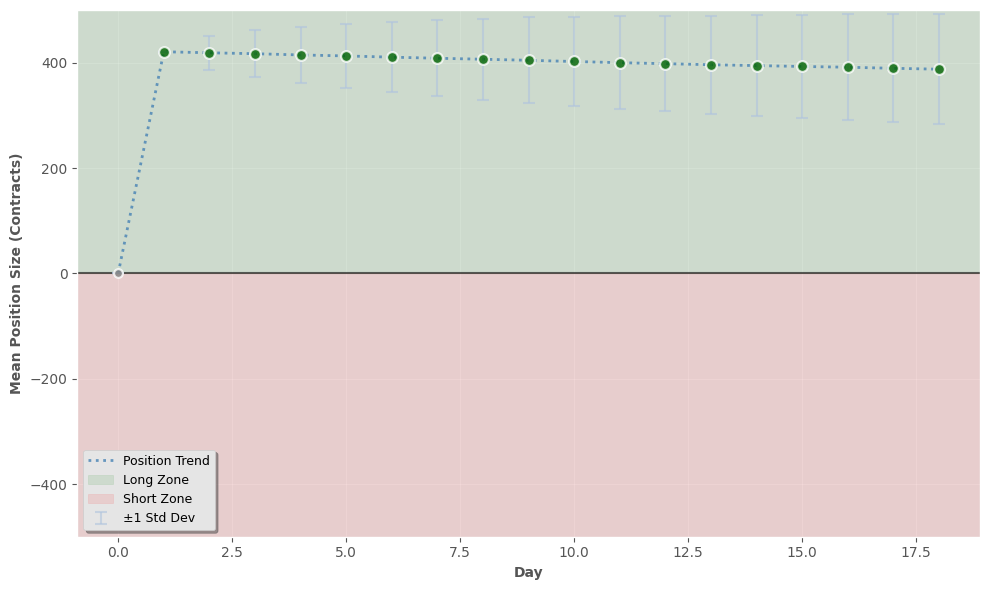

In [14]:
b1 = metrics(spositions2,straining2)

# ***Testing***

In [15]:
def simulating_OU(V0, timesteps,Vmean,vol,a,paths):
  dt = 1
  V = np.zeros((paths, timesteps+1))
  V[:,0] = V0
  DW = np.random.normal(0,1, size=(paths,timesteps))
  for i in range(timesteps):
    V[:,i+1] = V[:,i] - a*(V[:,i] - Vmean)*dt + vol*np.sqrt(dt)*DW[:,i]
  return V

futuressimulationT = np.exp(simulating_OU(np.log(13.2),18,Vmean,vol,a,10000))
returnsT = np.diff(futuressimulationT, axis=1) / futuressimulationT[:,:-1]

print(f"Futures simulation shape: {futuressimulationT}")
print(f"Price differences shape: {returnsT.shape}")
print(f"Initial price: {F0}")
print(f"Mean final price: {np.mean(futuressimulationT[:, -1]):.2f}")
print(f"Std final price: {np.std(futuressimulationT[:, -1]):.2f}")

Futures simulation shape: [[13.2     12.20781 12.82658 ... 16.0134  15.59929 15.33372]
 [13.2     13.48944 14.72741 ... 17.40029 17.3347  17.78101]
 [13.2     12.88459 13.74545 ... 10.56088 10.70179  9.32674]
 ...
 [13.2     12.92858 13.41959 ... 26.0184  26.29117 24.55319]
 [13.2     14.45699 15.3279  ... 21.50641 18.96461 18.04276]
 [13.2     13.38191 14.80454 ... 18.1806  16.8912  17.57238]]
Price differences shape: (10000, 18)
Initial price: 13.2
Mean final price: 15.38
Std final price: 4.20


In [16]:
tim = np.linspace(0,T,Timesteps+1)
Xtest = np.zeros((paths,Timesteps, 3))

for i in range(Timesteps):
  Xtest[:,i, 0] = tim[i]
  Xtest[:,i, 1] = futuressimulationT[:,i]
  if i > 0:
    Xtest[:,i, 2] = (futuressimulationT[:,i] - futuressimulationT[:,i-1])/futuressimulationT[:,i-1]
  else:
    Xtest[:,i, 2] = 0

print(f"Shape of Xtest: {Xtest.shape}")

pricemeanT = np.mean(Xtest[:,:,1])
pricestdT = np.std(Xtest[:,:,1])

Xtest = Xtest.copy()
Xtest[:,:,0] = Xtest[:,:,0]
Xtest[:,:,1] = (Xtest[:,:,1] - pricemeanT)/pricestdT
Xtest[:,:,2] = Xtest[:,:,2]

cutfuturessimulationT = tf.constant(futuressimulationT[:,:-1], dtype=tf.float32)

Shape of Xtest: (10000, 18, 3)


In [17]:
testpositions1 = (BpD/cutfuturessimulationT)*smodel1.predict(Xtest, batch_size=32)
testpositions1 = np.array(testpositions1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step



Trading metrics:
Position shape: (10000, 18)
Mean value of investment: 3416.3515625
Position range: [8.531615257263184, 1042.6585693359375]
Mean absolute position: 241.46
Std position: [  0.06229 130.10246 175.70586 188.25996 193.91306 196.15804 197.15294
 196.57896 195.9409  194.3729  192.95418 190.08594 188.01155 185.34003
 183.59422 180.28026 177.1485  174.00516]

Performance metrics:
Mean daily PnL: 30.18386459350586
Daily PnL std: 342.6915588378906
Mean Total PnL: 543.3095703125
Total PnL std: 1344.64794921875
Total PnL range: [-4225.20458984375, 12294.0947265625]
Mean modified Sharpe ratio: 0.40405339002609253
Mean wealth evolution: [ 58.77165 108.40755 154.29091 188.09819 225.94627 260.12674 287.47766
 318.53464 347.9921  374.6948  404.0059  426.33505 447.6398  464.54636
 482.05466 504.10236 526.18646 543.3104 ]
Wealth evolution std: [ 428.50812  588.22064  695.83704  776.9481   847.85614  911.7869
  973.7226  1026.3289  1066.9036  1102.709   1144.7057  1176.4762
 1207.304   12

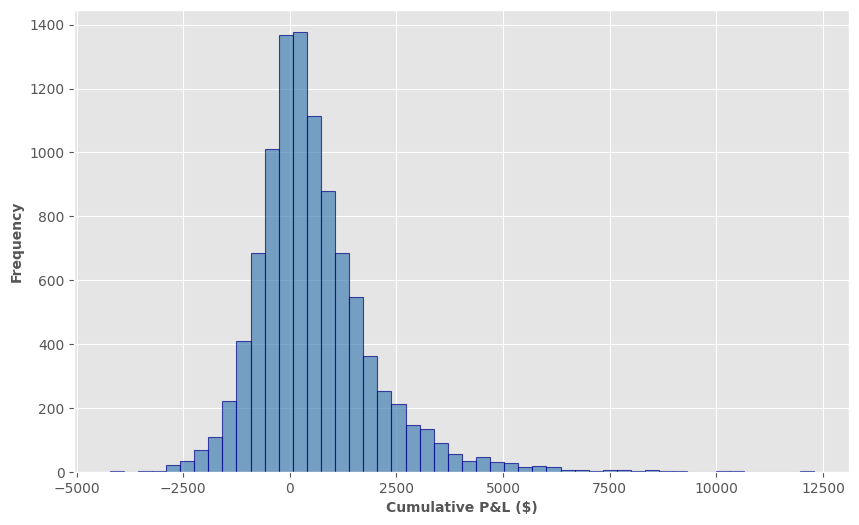

<Figure size 1000x600 with 0 Axes>

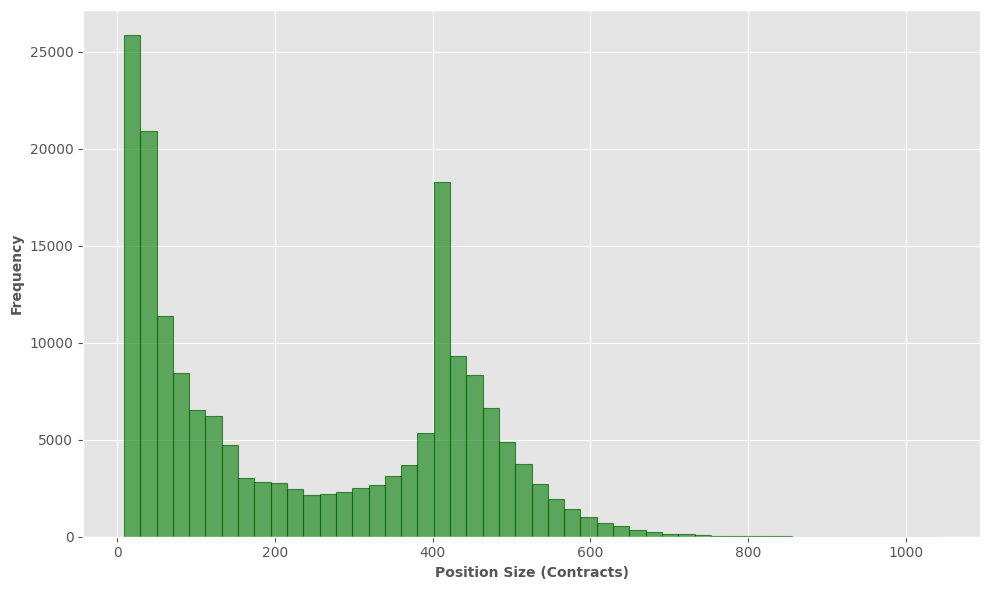

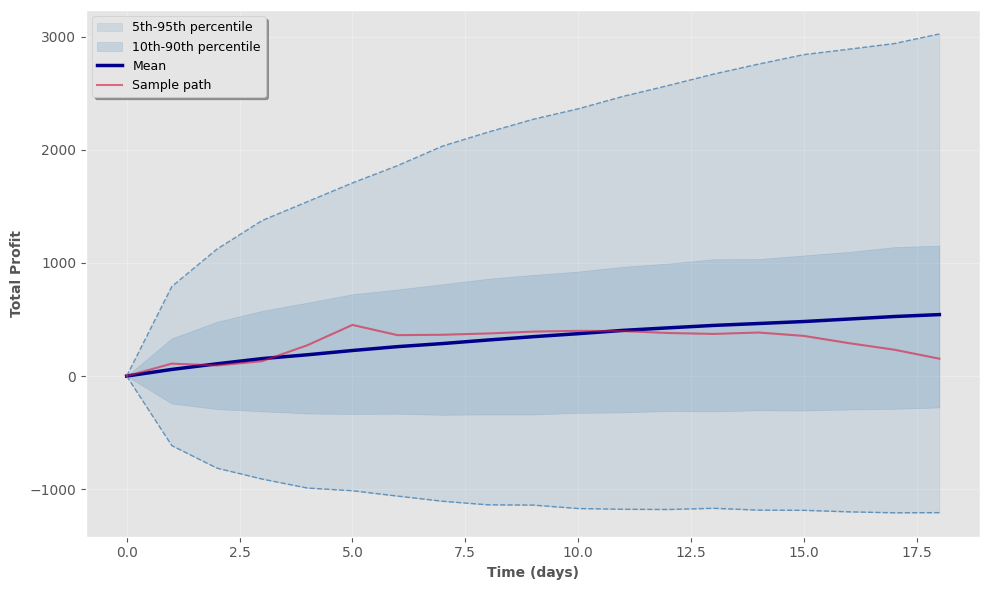

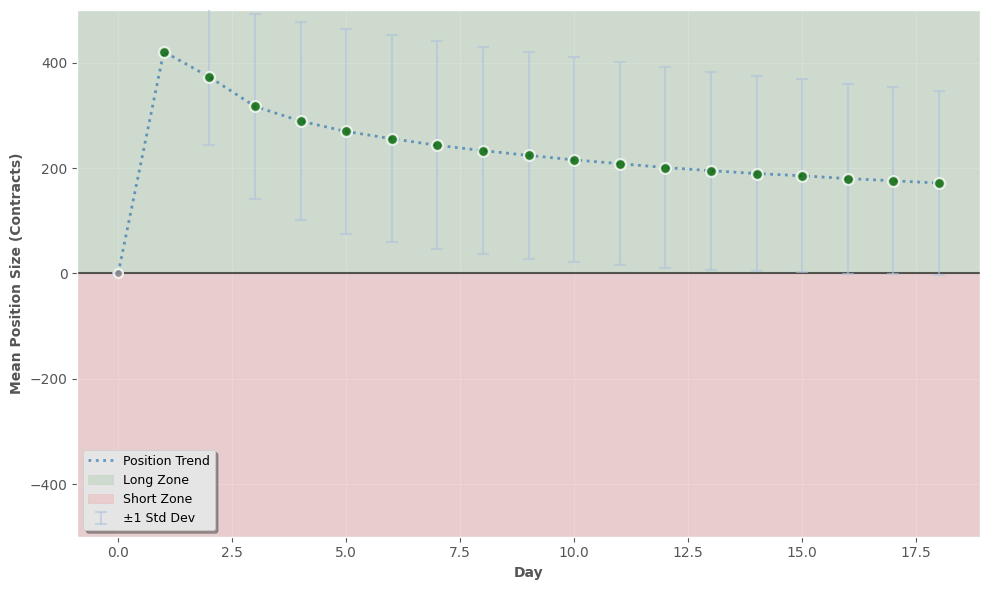

In [18]:
test1 = metrics(testpositions1,straining1)

In [19]:
testpositions2 = (BpD/cutfuturessimulationT)*smodel2.predict(Xtest, batch_size=32)
testpositions2 = np.array(testpositions2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step



Trading metrics:
Position shape: (10000, 18)
Mean value of investment: 5787.84033203125
Position range: [146.56361389160156, 1044.3470458984375]
Mean absolute position: 404.49
Std position: [  0.0246   31.92854  44.58822  53.92881  61.07103  67.36449  72.65495
  76.82233  80.75047  84.39738  88.07362  90.59642  93.32484  95.66876
  98.30419 100.16389 101.75873 103.18358]

Performance metrics:
Mean daily PnL: 50.5347900390625
Daily PnL std: 464.5770568847656
Mean Total PnL: 909.626220703125
Total PnL std: 1743.1248779296875
Total PnL range: [-4296.490234375, 13191.01171875]
Mean modified Sharpe ratio: 0.521836519241333
Mean wealth evolution: [ 58.75827 114.20512 176.17175 228.3276  285.3423  342.45065 395.40854
 449.3623  503.9411  555.77466 606.6142  655.0986  699.58386 741.0808
 781.155   828.8351  872.9459  909.6268 ]
Wealth evolution std: [ 428.40958  607.21594  743.258    850.942    943.9335  1040.0491
 1131.9783  1207.9984  1273.1494  1330.87    1396.8485  1449.6061
 1505.9384  1

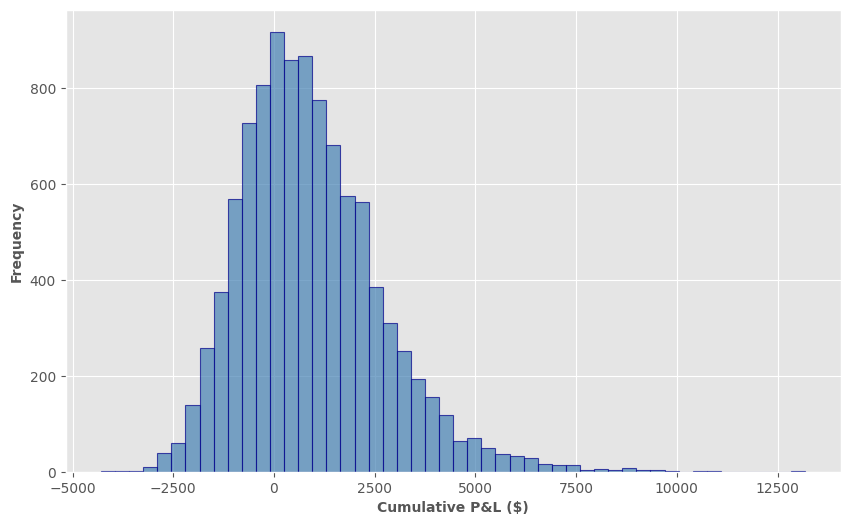

<Figure size 1000x600 with 0 Axes>

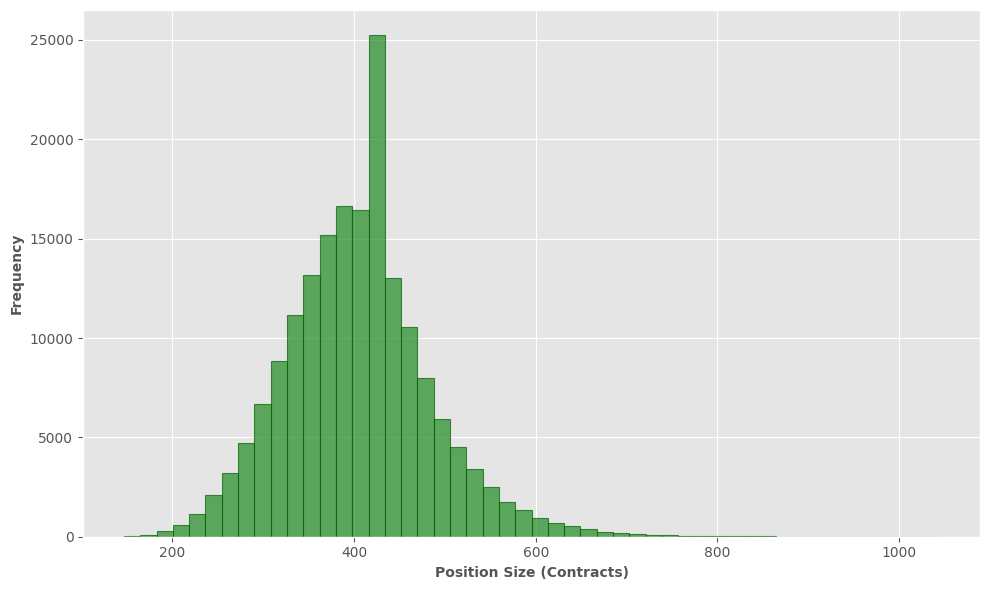

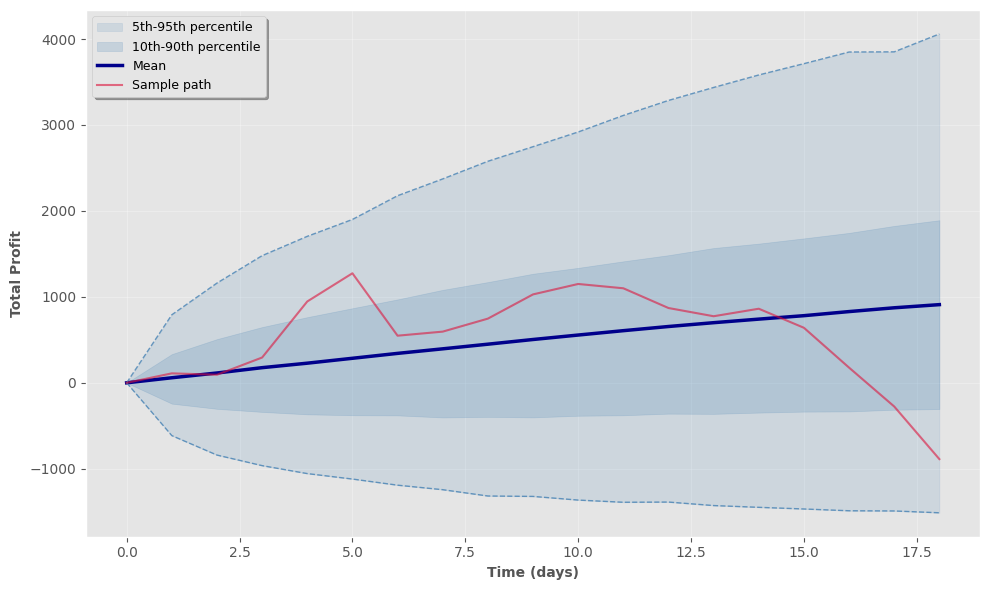

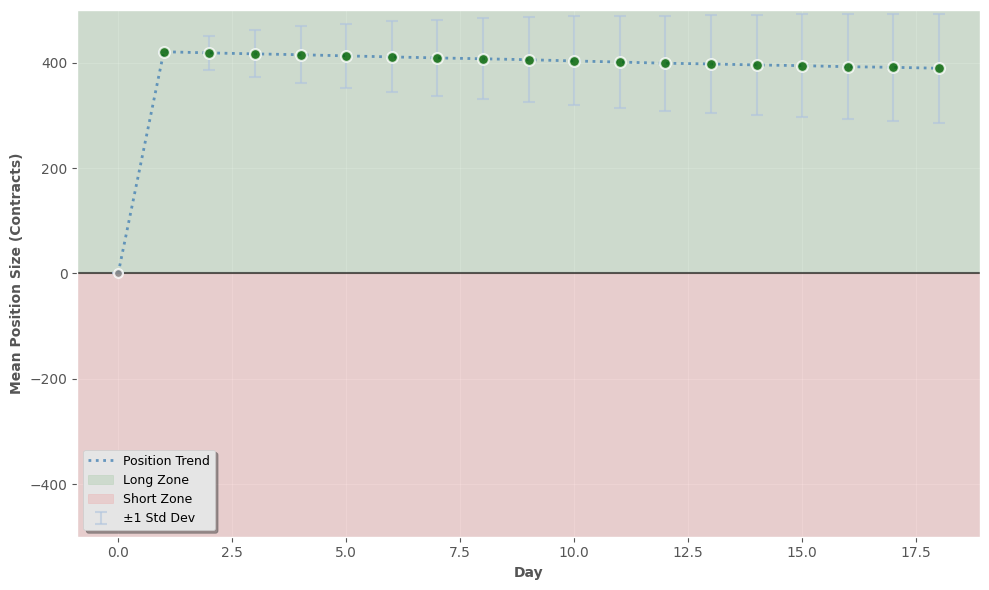

In [20]:
test2 = metrics(testpositions2, straining2)